*Q1: Try out the ‘Big Moves Monday’ strategy on the above data with the standard conditions as
taught in the class. Write a function for that strategy and run it twice with two different values of the
‘ibs’ parameter- once with the standard ‘ibs’ threshold value of 0.3 and then with the ‘ibs’ threshold
of 0.8. Compare the results (total return) of the strategy with the standard parameters and the one
with the tweaked parameters Comment on the results.*

#### Strategy # 2: Big moves on Mondays *(Long only)*

The [strategy](http://www.quantifiedstrategies.com/big-moves-on-mondays-update/) suggests that we go long on the S&P 500 on a Monday and close out our position on the Friday that week based on certain conditions. We assume that positions can be taken only in periods when markets are open from Monday to Friday in a week and the Friday in the previous week.

We calculate the following indicators and backtest the conditions shown below:

1. Calculate the 25-day average of `relative_range = (High - Low) / Close` and call it `rel_range_ma`.
2. The Monday `Close` must be lower than the previous Friday `Close` by at least 0.25 times of `rel_range_ma`. 
3. Create a variable `ibs = (Close - Low) / (High - Low)`. It must be lower than 0.3.
4. If conditions in 2, and 3 are met, go long on Monday `Close`.
5. Square off your position on Friday `Close`.

In [13]:
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

def download_data(ticker, start, end, timeframe='1d'):    
    data = yf.download(ticker, start, end, interval=timeframe)
    data.columns = [col[0].replace(r'/.+$', '') if isinstance(col, tuple) else col for col in data.columns]
    return data
    
df = download_data("SPY" ,'2015-1-1', '2025-1-1')
print(df)

/var/folders/36/85636rb57hngq6ntqqpkr0xh0000gn/T/ipykernel_11363/235061774.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end, interval=timeframe)
[*********************100%***********************]  1 of 1 completed

                 Close        High         Low        Open     Volume
Date                                                                 
2015-01-02  171.568069  172.779070  170.524112  172.361487  121465900
2015-01-05  168.469604  170.682788  168.160597  170.515758  169632600
2015-01-06  166.882782  169.304757  166.081017  168.778599  209151400
2015-01-07  168.962326  169.304747  167.768046  168.219029  125346700
2015-01-08  171.960571  172.177722  170.365415  170.382109  147217800
...                ...         ...         ...         ...        ...
2024-12-24  597.729553  597.769355  591.934154  592.520677   33160100
2024-12-26  597.769348  598.902533  594.528696  595.940247   41219100
2024-12-27  591.476868  594.230439  587.252104  593.991813   64969300
2024-12-30  584.727173  588.226291  580.939799  584.399176   56578800
2024-12-31  582.599915  587.132835  580.949738  586.407129   57052700

[2516 rows x 5 columns]


In [114]:
df['relative_range'] = (df['High']-df['Low'])/df['Close']
df['rel_range_ma'] = df['relative_range'].rolling(25).mean()
df['daily_return'] = df['Close'] - df['Close'].shift(1)

df.dropna(inplace = True)
df['ibs'] = (df['Close']-df['Low'])/(df['High']-df['Low'])

df['day_name'] = df.index.strftime('%A')

df['condition1'] = np.where((df['day_name'] == 'Monday') & (df['day_name'].shift(1) == 'Friday') & (df['day_name'].shift(-5) == 'Monday'),1,0) 
df['condition2'] = np.where((df['Close'].shift(1) - df['Close']) > (0.25*df['rel_range_ma']),1,0)
df['condition3'] = np.where(df['ibs'] < 0.3 , 1 , 0)

df['trade'] = np.where((df['condition1']==1) & (df['condition2']==1) & (df['condition3']==1),1,0)

df['p&l'] = np.where(df['trade']==1,df['Close'].shift(-4) - df['Close'],0)
df['buy_hold_returns']=df['daily_return'].cumsum()
df['p_l_returns']=df['p&l'].cumsum()

print(df.head(40))
print(f'overall profit and loss = {df['p&l'].sum()}', )

                 Close        High         Low        Open     Volume  \
Date                                                                    
2015-02-06  171.668228  173.079660  171.142070  172.511741  125672000   
2015-02-09  170.899918  171.743430  170.490682  171.016840   87219000   
2015-02-10  172.720566  172.979465  170.941659  171.943868   96164200   
2015-02-11  172.820816  173.255106  171.902142  172.553570   91087800   
2015-02-12  174.482773  174.541241  172.854203  173.622553   97545900   
2015-02-13  175.201019  175.251127  174.349147  174.608059   93670400   
2015-02-17  175.476624  175.652014  174.633111  174.883650   76968200   
2015-02-18  175.493286  175.568448  174.833498  175.100757   80652900   
2015-02-19  175.368073  175.735547  174.750058  174.892035   91462500   
2015-02-20  176.420380  176.495541  174.324106  174.950480  140896400   
2015-02-23  176.395294  176.395294  175.785614  176.169796   74411100   
2015-02-24  176.896378  177.096822  176.019451  176

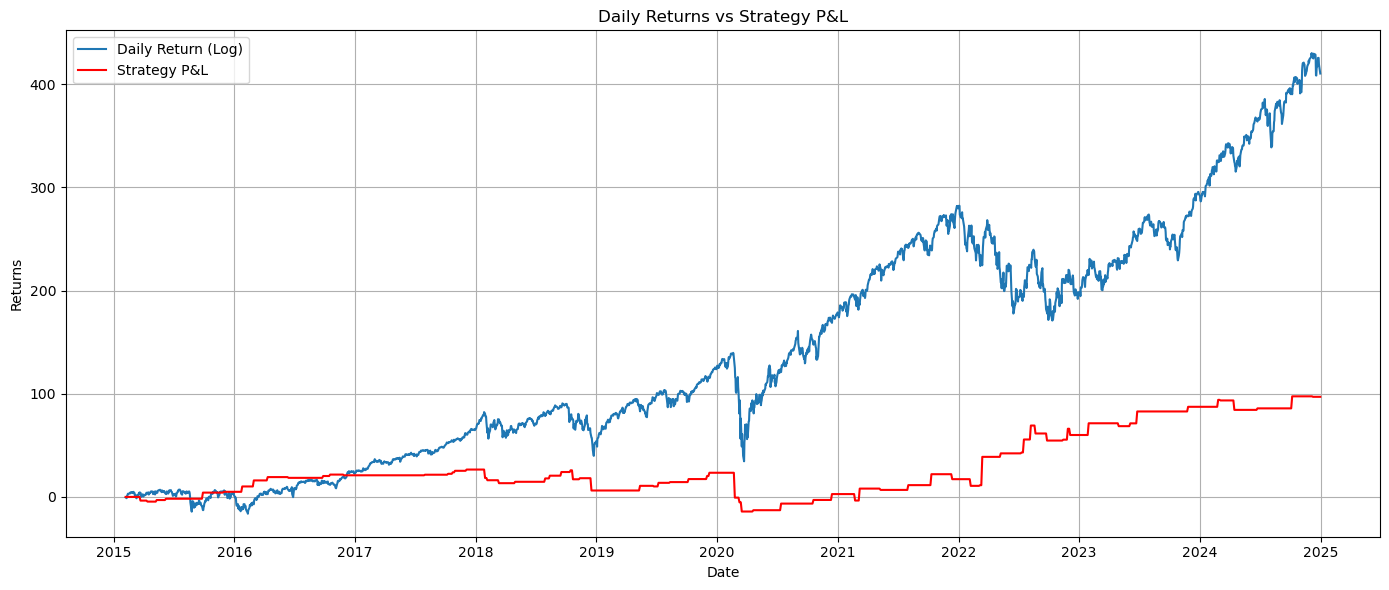

In [116]:

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['buy_hold_returns'], label='Daily Return (Log)',)
plt.plot(df.index, df['p_l_returns'], label='Strategy P&L', color='red')
plt.title('Daily Returns vs Strategy P&L')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Q2: You have seen a strategy based on the MACD indicator in the class. Now back-test the following
strategy based on Bollinger bands:
1. Create 20-day (+/- 2 standard deviations) Bollinger bands on the adjusted close price for the
above equity.
2. Buy when the price crosses the lower band from the top and hold until the price crosses the
upper band from below the next time.
3. Sell when the price crosses the upper band from below and hold until the price crosses the
lower band from top the next time.
4. Once we get into a trade, we always have an open position at all times.
Compare the total returns of the above strategy with a simple ‘buy & hold’ strategy. Comment on
your findings.

In [119]:
nifty_data = download_data("^NSEI" ,'2015-1-1', '2025-6-24')


/var/folders/36/85636rb57hngq6ntqqpkr0xh0000gn/T/ipykernel_3257/1622365130.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end, interval=timeframe)
[*********************100%***********************]  1 of 1 completed


buy and hold total log return : 1.0258351843290934
strategy total log return : 0.17614193787617885
buy and hold total % return : 1.7894241713342103
strategy total % return : 0.1926073227884011


/var/folders/36/85636rb57hngq6ntqqpkr0xh0000gn/T/ipykernel_3257/2820590882.py:14: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  nifty_data['position'] = nifty_data['signal'].replace(to_replace=0, method='ffill').shift(1)
/var/folders/36/85636rb57hngq6ntqqpkr0xh0000gn/T/ipykernel_3257/2820590882.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nifty_data['position'].fillna(0, inplace=True)


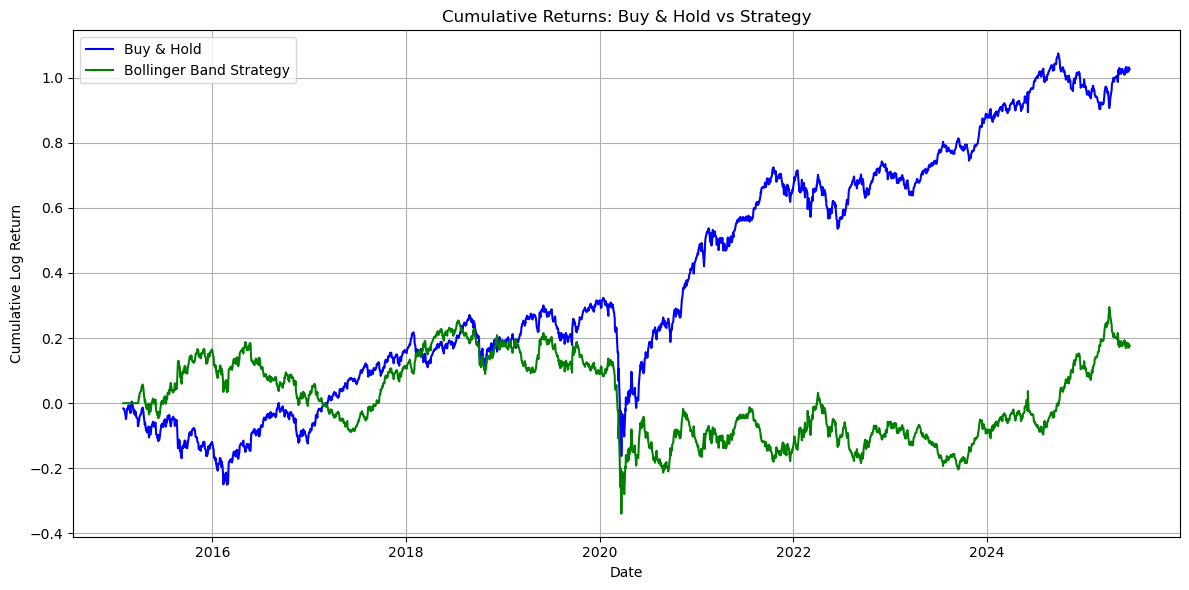

In [121]:
def backtest_bollinger_band_strategy():
    nifty_data['daily_return'] = np.log(nifty_data['Close']/nifty_data['Close'].shift(1))
    nifty_data['middle_band'] = nifty_data['Close'].rolling(20).mean()
    nifty_data['upper_band'] = nifty_data['middle_band'] + nifty_data['Close'].rolling(20).std()*2
    nifty_data['lower_band'] = nifty_data['middle_band'] - nifty_data['Close'].rolling(20).std()*2

    nifty_data.dropna(inplace=True)

    nifty_data['signal'] = 0
    nifty_data.loc[(nifty_data['Close'] > nifty_data['lower_band']) & (nifty_data['Close'].shift(1) <= nifty_data['lower_band'].shift(1)), 'signal'] = 1
    nifty_data.loc[(nifty_data['Close'] < nifty_data['upper_band']) & (nifty_data['Close'].shift(1) >= nifty_data['upper_band'].shift(1)), 'signal'] = -1

    # Forward fill position and shift by 1 day to avoid lookahead bias
    nifty_data['position'] = nifty_data['signal'].replace(to_replace=0, method='ffill').shift(1)
    nifty_data['position'].fillna(0, inplace=True)


    nifty_data['strategy_return'] = nifty_data['daily_return'] * nifty_data['position']

    nifty_data['buy_hold_cum_return'] = nifty_data['daily_return'].cumsum()
    nifty_data['strategy_cum_return'] = nifty_data['strategy_return'].cumsum()
    
    print(f"buy and hold total log return : {nifty_data['daily_return'].sum()}")
    print(f"strategy total log return : {nifty_data['strategy_return'].sum()}")

    print(f"buy and hold total % return : {np.exp(nifty_data['daily_return'].sum())-1}")
    print(f"strategy total % return : {np.exp(nifty_data['strategy_return'].sum())-1}")

    plt.figure(figsize=(12, 6))
    plt.plot(nifty_data.index, nifty_data['buy_hold_cum_return'], label='Buy & Hold', color='blue')
    plt.plot(nifty_data.index, nifty_data['strategy_cum_return'], label='Bollinger Band Strategy', color='green')
    plt.title("Cumulative Returns: Buy & Hold vs Strategy")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Log Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # print(nifty_data.head(25))
    
backtest_bollinger_band_strategy()

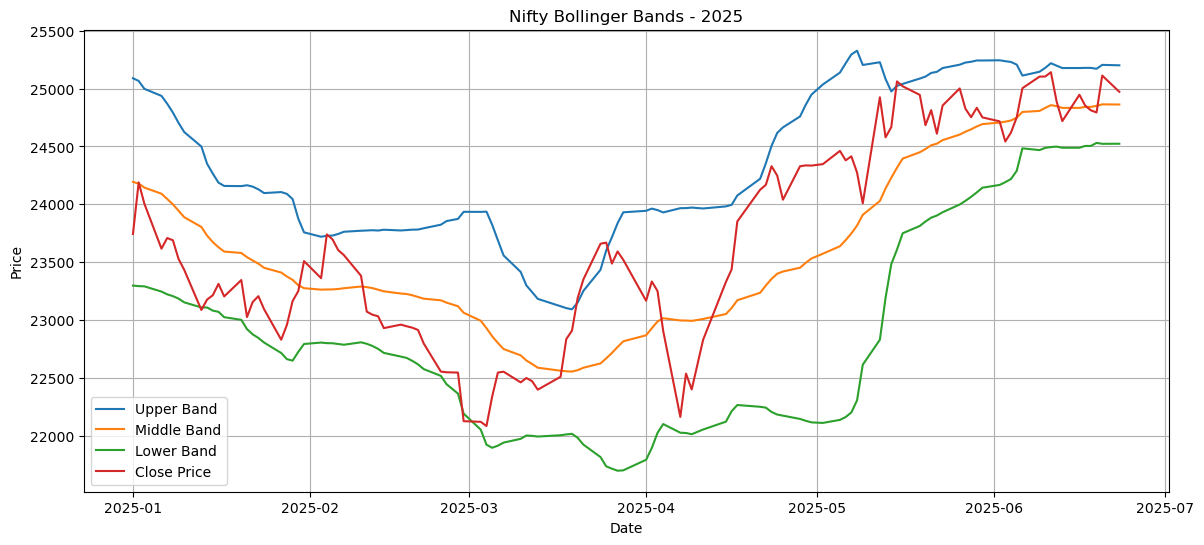

In [125]:
def plot_bollinger_band():
    
    nifty_2025 = nifty_data.loc['2025-01-01':'2025-06-24']  # Filters only 2025 data
    
    plt.figure(figsize=(14, 6))
    plt.plot(nifty_2025.index, nifty_2025['upper_band'], label='Upper Band')
    plt.plot(nifty_2025.index, nifty_2025['middle_band'], label='Middle Band')
    plt.plot(nifty_2025.index, nifty_2025['lower_band'], label='Lower Band')
    plt.plot(nifty_2025.index, nifty_2025['Close'], label='Close Price')
    plt.legend()
    plt.title("Nifty Bollinger Bands - 2025")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()
    
plot_bollinger_band()

Q3: Write a customized function that computes returns for the exponential moving average (EMA)
strategy (discussed in class) for different windows (spans). Find the optimal value of span between 1
and 30 which produces the best overall total return.

We determine the 12-period simple moving average (referred to as 'EMA12') and compare it with the price at that time. We (subjectively) select 12 since EMA12 would be the average price over one hour.

There are two conditions which we check.

If the price is greater than the EMA12, we go long. We continue to stay invested until the square-off condition is satisfied.

When the price becomes less than the ema12, we square off our long position.

Our trading rules can be stated as

Buy when price > ema12
Square off when price <= ema12

In [5]:
airtel = download_data("BHARTIARTL.NS" ,'2025-4-27', '2025-6-25','5m')
print(airtel.head())

/var/folders/36/85636rb57hngq6ntqqpkr0xh0000gn/T/ipykernel_11363/1622365130.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end, interval=timeframe)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BHARTIARTL.NS']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-4-27 -> 2025-6-25) (Yahoo error = "5m data not available for startTime=1745692200 and endTime=1750789800. The requested range must be within the last 60 days.")')


Empty DataFrame
Columns: [Adj Close, Close, High, Low, Open, Volume]
Index: []


In [214]:
def backtest_ema(df1,period):

    df = df1.copy()
    df['cc_return'] =  df['Close'].pct_change()
    df['ema'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['position'] = np.where(df['Close'] > df['ema'],1,0)
    df['daily_strategy_return'] = df['cc_return'] * df['position'].shift(1)
    df['strategy_return'] = (1+df['daily_strategy_return']).cumprod()
    df['buy_and_hold_return'] = (1+df['cc_return']).cumprod()

    # plt.figure(figsize=(14, 6))
    # plt.plot(df.index, df['strategy_return'], label='Statergy Returns')
    # plt.plot(df.index, df['buy_and_hold_return'], label='Buy and Hold return')
    # # plt.plot(df.index, df['Close'], label='Close', alpha=0.5)
    # # plt.plot(df.index, df['ema'], label=f'EMA {span}', linestyle='--')
    # plt.legend()
    # plt.title("EMA statergy")
    # plt.xlabel("Date")
    # plt.ylabel("Price")
    # plt.grid(True)
    # plt.show()
    
    bh_return = df['buy_and_hold_return'].iloc[-1]
    strat_return = df['strategy_return'].iloc[-1]  
    print(f"Period: {period}, Strategy Return: {strat_return:.4f}, Buy & Hold: {bh_return:.4f}")

    return strat_return

best_ema = 0
best_returns = 0
for i in range(1,31):
    strategy_returns = backtest_ema(airtel,i)
    if strategy_returns > best_returns:
        best_returns = strategy_returns
        best_ema = i

print(f"\nBest EMA Period: {best_ema}")
print(f"Best Strategy Return: {best_returns:.4f}")
    

Period: 1, Strategy Return: 1.0000, Buy & Hold: 1.0612
Period: 2, Strategy Return: 0.9385, Buy & Hold: 1.0612
Period: 3, Strategy Return: 0.9384, Buy & Hold: 1.0612
Period: 4, Strategy Return: 0.9543, Buy & Hold: 1.0612
Period: 5, Strategy Return: 0.9571, Buy & Hold: 1.0612
Period: 6, Strategy Return: 0.9584, Buy & Hold: 1.0612
Period: 7, Strategy Return: 0.9677, Buy & Hold: 1.0612
Period: 8, Strategy Return: 0.9782, Buy & Hold: 1.0612
Period: 9, Strategy Return: 0.9652, Buy & Hold: 1.0612
Period: 10, Strategy Return: 0.9657, Buy & Hold: 1.0612
Period: 11, Strategy Return: 0.9686, Buy & Hold: 1.0612
Period: 12, Strategy Return: 0.9673, Buy & Hold: 1.0612
Period: 13, Strategy Return: 0.9682, Buy & Hold: 1.0612
Period: 14, Strategy Return: 0.9702, Buy & Hold: 1.0612
Period: 15, Strategy Return: 0.9591, Buy & Hold: 1.0612
Period: 16, Strategy Return: 0.9580, Buy & Hold: 1.0612
Period: 17, Strategy Return: 0.9580, Buy & Hold: 1.0612
Period: 18, Strategy Return: 0.9498, Buy & Hold: 1.0612
P

Q4: The moving average crossover (MAC) code was implemented in the lecture, where we always
have an open position. Try the strategy with the original conditions, tweak it and calculate returns
where short selling is not allowed. Plot a graph comparing returns from buy-and-hold, no short
selling, and the one we did in class. Comment on your results.

* Go long on day $n+2$ when SMA50 > SMA200 on day $n+1$ and SMA50 < SMA200 on day $n$
* Go short on day $n+2$ when SMA50 < SMA200 on day $n+1$ and SMA50 > SMA200 on day $n$

In [19]:
titan = download_data('TITAN.NS','2015-1-1', '2025-1-1')
titan

/var/folders/36/85636rb57hngq6ntqqpkr0xh0000gn/T/ipykernel_11363/235061774.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end, interval=timeframe)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2015-01-01,363.815338,366.449599,361.899512,365.252208,269753
2015-01-02,366.689117,372.149234,363.815378,363.815378,623981
2015-01-05,369.658661,373.202951,366.689124,367.838632,551576
2015-01-06,357.014191,367.263842,353.661495,366.114364,519159
2015-01-07,358.834198,361.516343,354.427793,357.205734,397373
...,...,...,...,...,...
2024-12-24,3353.399902,3419.000000,3338.199951,3385.350098,485245
2024-12-26,3323.050049,3371.850098,3312.649902,3365.000000,637094
2024-12-27,3309.199951,3345.000000,3301.100098,3319.850098,568989


In [21]:
tata_motors = download_data('TATAMOTORS.NS','2015-6-1', '2025-5-28')
print(tata_motors)

/var/folders/36/85636rb57hngq6ntqqpkr0xh0000gn/T/ipykernel_11363/235061774.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end, interval=timeframe)
[*********************100%***********************]  1 of 1 completed

                 Close        High         Low        Open    Volume
Date                                                                
2015-06-01  464.948151  475.634922  463.913960  475.634922   4610219
2015-06-02  459.924927  471.202648  458.004252  465.982396   6237231
2015-06-03  449.976837  461.697799  428.160083  459.974127   9702740
2015-06-04  444.411835  451.552761  438.748342  449.976826   8001049
2015-06-05  435.448730  442.786629  432.887841  438.945310  11195670
...                ...         ...         ...         ...       ...
2025-05-21  720.604370  723.281366  711.879398  712.870873   8998596
2025-05-22  711.334106  718.819734  704.592085  718.819734  10046820
2025-05-23  712.127258  715.646984  708.904963  712.622996   7915166
2025-05-26  722.785583  731.708862  715.052087  715.845256  13017400
2025-05-27  710.342590  723.132587  709.103246  722.785595  12223125

[2466 rows x 5 columns]


In [23]:
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

In [140]:
def backtest_moving_average_crossover(sma, lma, data, shortingAllowed=True):

    if sma >= lma:
        return 0
        
    df = data.copy()
    df['daily_log_returns'] = np.log( df['Close'] / df['Close'].shift(1) )
    df['sma'] = df['Close'].rolling(sma).mean()
    df['lma'] = df['Close'].rolling(lma).mean()
        
    if shortingAllowed:
        df['position'] = np.where(df['sma'] > df['lma'], 1, -1)
    else:
        df['position'] = np.where(df['sma'] > df['lma'], 1, 0)

    df['position'] = df['position'].shift(1)

    df.dropna(inplace=True)

    df['daily_strategy_return'] = df['position'] * df['daily_log_returns'];
    df['cumulative_buy_and_hold_return'] = df['daily_log_returns'].cumsum()
    df['cumulative_strategy_return'] = df['daily_strategy_return'].cumsum()

    #df[['cumulative_buy_and_hold_return','cumulative_strategy_return']].plot()

    buy_and_hold_return = np.exp(df['cumulative_buy_and_hold_return'].iloc[-1]) - 1
    strategy_return = np.exp(df['cumulative_strategy_return'].iloc[-1]) - 1

    print(f"sma : {sma} || lma : {lma} || strategy returns : {strategy_return} || buy and hold returns : {buy_and_hold_return}")

    p0 = data['Close'].iloc[0]     # 2015 price
    p1 = data['Close'].iloc[-1]    # 2025 price

    buy_and_hold_log_return = np.log(p1 / p0) 
    print(p0)
    print(p1)
    print(buy_and_hold_log_return)
    print(df['daily_log_returns'].sum())
    print(df['cumulative_buy_and_hold_return'].iloc[-1])


    df_2029 = df.loc['2017-01-01':'2023-01-01']

    df_2029['position'] = np.where(df_2029['position']==1,df_2029['Close'].max(),df_2029['Close'].min())

    df_2029[['Close','sma','lma','position']].plot(figsize=(14, 6))

    df_2019[['cumulative_buy_and_hold_return','cumulative_strategy_return']].plot(figsize=(14, 6))

    return strategy_return;

sma : 50 || lma : 200 || strategy returns : 1.5185555212444948 || buy and hold returns : 0.9983173153487634
464.9481506347656
710.3425903320312
0.42382147989459606
0.6923054841072305
0.6923054841072306


/var/folders/36/85636rb57hngq6ntqqpkr0xh0000gn/T/ipykernel_11363/3168265688.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2029['position'] = np.where(df_2029['position']==1,df_2029['Close'].max(),df_2029['Close'].min())


NameError: name 'df_2019' is not defined

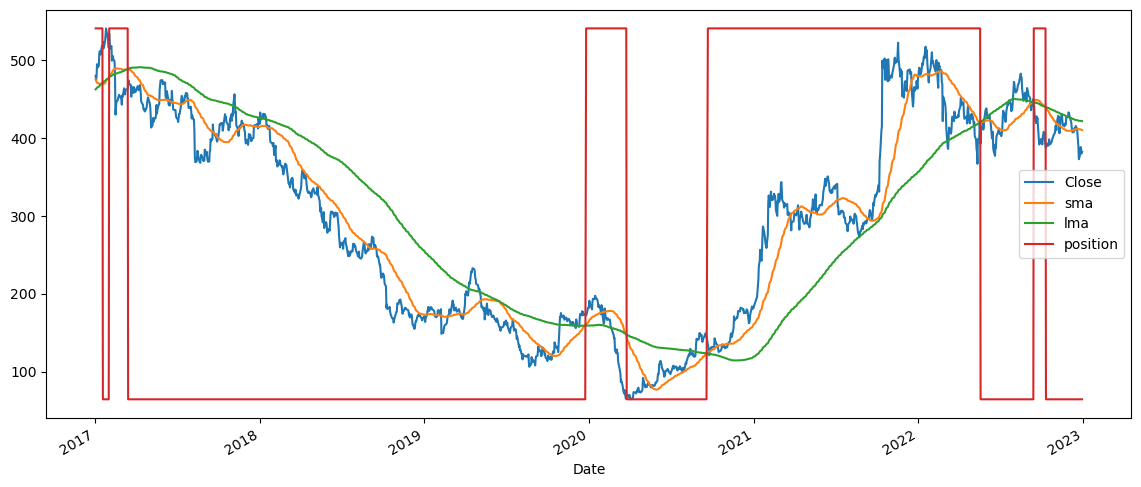

In [142]:
tata_returns = backtest_moving_average_crossover(50,200,tata_motors)

In [70]:

best_sma = 0
best_lma = 0
best_return = -np.inf

for i in range(49,51):
    for j in range(199,201):
        returns = backtest_moving_average_crossover(i,j,titan)
        if returns > best_return:
            best_sma = i
            best_lma = j
            best_return = returns

print(f" best sma : {best_sma} || best ema : {best_lma} || best return : {best_return}")

sma : 49 || lma : 199 || strategy returns : -0.41628408496352265 || buy and hold returns : 8.613348981744068
363.8153381347656
3253.14990234375
2.190732580579693
2.2631526515292912
2.2631526515292903
sma : 49 || lma : 200 || strategy returns : -0.35493221283032383 || buy and hold returns : 8.581951138701037
363.8153381347656
3253.14990234375
2.190732580579693
2.259881239168137
2.2598812391681373
sma : 50 || lma : 199 || strategy returns : -0.43714264821870463 || buy and hold returns : 8.613348981744068
363.8153381347656
3253.14990234375
2.190732580579693
2.2631526515292912
2.2631526515292903
sma : 50 || lma : 200 || strategy returns : -0.41968329841707974 || buy and hold returns : 8.581951138701037
363.8153381347656
3253.14990234375
2.190732580579693
2.259881239168137
2.2598812391681373
 best sma : 49 || best ema : 200 || best return : -0.35493221283032383
